In [1]:
import os
import sys

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join("..", "src")))
import logging
import pandas as pd
import scanpy as sc
import decoupler as dc
from utils import load_config

logging.basicConfig(level=logging.DEBUG)

# Load the configuration file
config = load_config("../config.yaml")


# # Function to load gene expression data
# def load_gene_expression_data(file_path, chunk_size=2000):
#     """
#     Load gene expression data in chunks to handle large file sizes.

#     Args:
#         file_path (str): Path to the preprocessed gene expression file.
#         chunk_size (int): Size of chunks to load the data.

#     Returns:
#         pd.DataFrame: Combined gene expression matrix.
#     """
#     logging.info("Loading gene expression dataset in chunks...")
#     chunks = []
#     for chunk in pd.read_csv(file_path, chunksize=chunk_size):
#         chunks.append(chunk)
#     mat = pd.concat(chunks, axis=0)
#     logging.info(f"Gene expression matrix loaded with shape: {mat.shape}")
#     return mat


# # # Load the gene expression matrix
# gene_df = load_gene_expression_data(config["data_paths"]["preprocessed_gene_file"])
# # Add an increasing integer ID column
# gene_df.insert(0, "ID", range(1, len(gene_df) + 1))

In [2]:
gene_df.shape

(31159, 12332)

In [3]:
# Extract perturbation IDs and drop target/metadata columns
pert_ids = gene_df["ID"]
mat = gene_df.drop(columns=["ID", "viability", "cell_mfc_name", "pert_dose"])

# Create AnnData object for Decoupler
adata = sc.AnnData(
    X=mat.values, obs=pd.DataFrame(index=pert_ids), var=pd.DataFrame(index=mat.columns)
)
logging.debug(f"AnnData object created with shape: {adata.shape}")

d:\Programming\5ARG45\5ARG45\.venv\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
DEBUG:root:AnnData object created with shape: (31159, 12328)


In [6]:
import decoupler as dc
# Load CollecTRI network
net = dc.get_dorothea(organism="human", split_complexes=False)

# Verify network format
net.shape

DEBUG:root:Initialized `<Downloader[options=Options(url='https://omnipathdb.org', fallback_urls=('http://no-tls.omnipathdb.org',), static_url='http://no-tls.static.omnipathdb.org/resources', license=None, cache=<FileCache[size=2, path='C:\\Users\\20191678\\.cache\\omnipathdb']>, autoload=True, convert_dtypes=True, num_retries=3, timeout=600.0, chunk_size=8196)]>`
DEBUG:root:Attempting server `https://omnipathdb.org/`.
DEBUG:root:Looking up in cache: `https://omnipathdb.org/interactions?datasets=dorothea&dorothea_levels=A%2CB%2CC%2CD&fields=curation_effort%2Cdorothea_level%2Cevidences%2Cextra_attrs%2Creferences%2Csources&format=tsv&genesymbols=1&organisms=9606` ('92d0a2c2bf7a46e2566266f15c0bd8a1').
INFO:root:Downloading data from `https://omnipathdb.org/interactions?datasets=dorothea&dorothea_levels=A%2CB%2CC%2CD&fields=curation_effort%2Cdorothea_level%2Cevidences%2Cextra_attrs%2Creferences%2Csources&format=tsv&genesymbols=1&organisms=9606`
DEBUG:urllib3.connectionpool:Starting new HTTP

0.00B [00:00, ?B/s]

DEBUG:root:Caching result to `<FileCache[size=2, path='C:\\Users\\20191678\\.cache\\omnipathdb']>['92d0a2c2bf7a46e2566266f15c0bd8a1']`
DEBUG:root:Keeping evidences only from datasets: dorothea; and resources: any.


(32275, 4)

In [ ]:
net["target"].value_counts()

KeyError: 'targets'

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Programming\\5ARG45\\5ARG45\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Programming\\5ARG45\\5ARG45\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Programming\\5ARG45\\5ARG45

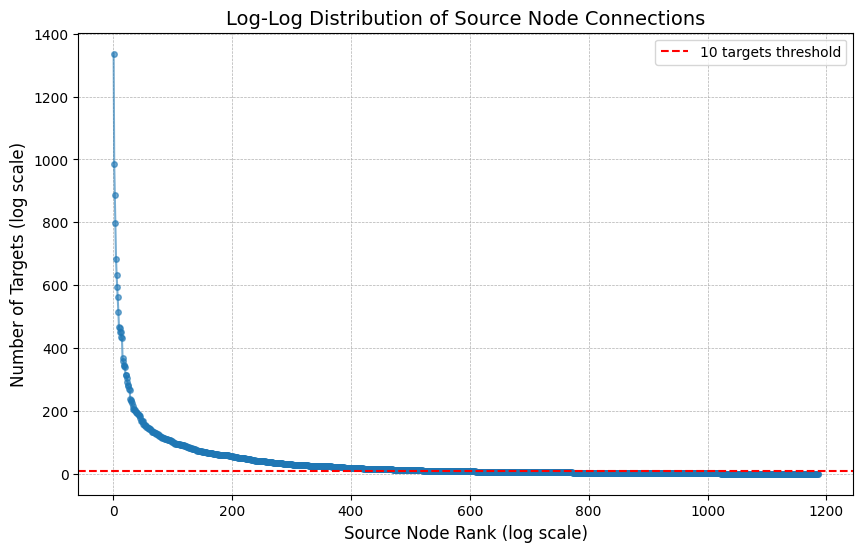

In [6]:
import matplotlib.pyplot as plt

# Count occurrences and sort by connection counts
counts = net["source"].value_counts().sort_values(ascending=False)

# Plot the source node connections
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(counts) + 1), counts.values, marker="o", alpha=0.6, markersize=4)

# Log-log scale
# plt.xscale("log")
# plt.yscale("log")

# Add labels and grid
plt.xlabel("Source Node Rank (log scale)", fontsize=12)
plt.ylabel("Number of Targets (log scale)", fontsize=12)
plt.title("Log-Log Distribution of Source Node Connections", fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Highlight the threshold (<10 targets)
plt.axhline(10, color="red", linestyle="--", label="10 targets threshold")
plt.legend()

plt.show()

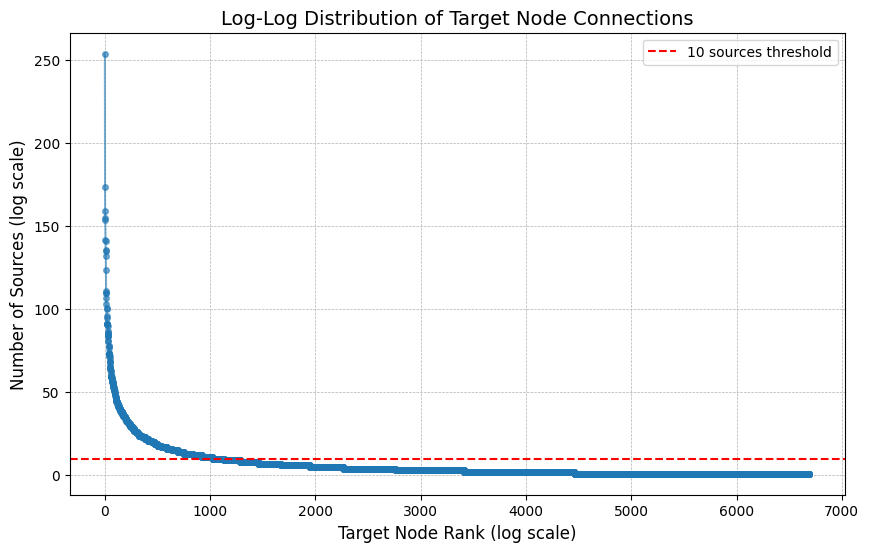

In [7]:
import matplotlib.pyplot as plt

# Count occurrences and sort by connection counts
counts = net["target"].value_counts().sort_values(ascending=False)

# Plot the source node connections
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(counts) + 1), counts.values, marker="o", alpha=0.6, markersize=4)

# Log-log scale
# plt.xscale("log")
# plt.yscale("log")

# Add labels and grid
plt.xlabel("Target Node Rank (log scale)", fontsize=12)
plt.ylabel("Number of Sources (log scale)", fontsize=12)
plt.title("Log-Log Distribution of Target Node Connections", fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Highlight the threshold (<10 sources)
plt.axhline(10, color="red", linestyle="--", label="10 sources threshold")
plt.legend()

plt.show()

In [8]:
# Check alignment between network targets and gene expression
shared_genes = set(net["target"]).intersection(adata.var_names)
logging.debug(f"Number of shared genes: {len(shared_genes)}")
assert (
    len(shared_genes) > 0
), "No shared genes between network and gene expression matrix!"

# Filter the network for matching genes
net_filtered = net[net["target"].isin(shared_genes)]
logging.debug(f"Filtered network has {len(net_filtered)} interactions.")

DEBUG:root:Number of shared genes: 5576
DEBUG:root:Filtered network has 39490 interactions.


In [ ]:
import logging

import pandas as pd
import scanpy as sc

from utils import load_sampled_data

X = load_sampled_data(
    config["data_paths"]["preprocessed_gene_file"],
    sample_size=1000,
    use_chunks=True,
    chunk_size=2000,
)



In [30]:
import logging
import pandas as pd
import scanpy as sc
from typing import Optional


def run_tf_activity_inference(
    X: pd.DataFrame, net: pd.DataFrame, min_n: int = 1
) -> pd.DataFrame:
    """
    Run TF activity inference on the input data.

    Args:
        X (pd.DataFrame): Gene expression matrix, including metadata columns.
        net (pd.DataFrame): Regulatory network for TF activity inference.
        min_n (int): Minimum number of targets for each TF.

    Returns:
        pd.DataFrame: TF activity matrix with metadata reattached.

    Raises:
        ValueError: If no shared genes are found between network and gene expression matrix.
    """
    # Define metadata columns
    metadata_cols = {"cell_mfc_name", "viability", "pert_dose"}
    missing_cols = metadata_cols - set(X.columns)

    if missing_cols:
        raise ValueError(f"Missing expected metadata columns: {missing_cols}")

    metadata = X[list(metadata_cols)]
    gene_expression = X.drop(columns=metadata_cols)

    # Filter the network for shared genes
    shared_genes = set(net["target"]).intersection(gene_expression.columns)
    if not shared_genes:
        raise ValueError(
            "No shared genes found between network and gene expression matrix!"
        )

    logging.debug(f"Number of shared genes: {len(shared_genes)}")

    # Filter network and gene expression data
    net_filtered = net[net["target"].isin(shared_genes)]
    logging.debug(f"Filtered network has {len(net_filtered)} interactions.")
    gene_expression = gene_expression[list(shared_genes)]

    # Create AnnData object
    adata = sc.AnnData(
        X=gene_expression.values,
        obs=pd.DataFrame(index=gene_expression.index),
        var=pd.DataFrame(index=gene_expression.columns),
    )
    logging.info(f"AnnData object created with shape: {adata.shape}")

    # Run ULM for TF activity inference
    dc.run_ulm(
        mat=adata,
        net=net_filtered,
        source="source",
        target="target",
        weight="weight",
        min_n=min_n,
        use_raw=False,
    )

    # Extract TF activity estimates
    tf_activity = pd.DataFrame(adata.obsm["ulm_estimate"], index=adata.obs.index)
    tf_activity.index = tf_activity.index.astype(int)  # Convert index to integers

    # Reattach metadata columns
    tf_activity = tf_activity.join(metadata)

    return tf_activity

In [31]:
tf_activity = run_tf_activity_inference(X, net_filtered, min_n=1)
tf_activity

DEBUG:root:Number of shared genes: 5576
DEBUG:root:Filtered network has 39490 interactions.
d:\Programming\5ARG45\5ARG45\.venv\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:root:AnnData object created with shape: (1000, 5576)


,ABL1,ADNP2,AEBP1,AEBP2,AHR,AHRR,AIP,AIRE,AKNA,ALX3,...,ZNF804A,ZNF91,ZSCAN18,ZSCAN26,ZSCAN9,ZXDA,ZXDC,cell_mfc_name,viability,pert_dose
0,-0.681761,-0.409805,0.349129,-0.889430,1.710857,-1.676612,0.640833,-0.802962,-0.396116,-0.661009,...,-0.506996,0.391722,-0.359054,0.412577,-0.359054,-0.561636,0.802754,PC3,0.452896,10.0000
1,0.570504,0.995247,0.403061,0.476148,1.968568,0.053115,-0.363969,-0.011594,1.021980,0.446080,...,-0.660643,0.333540,-0.389010,-0.984666,-0.389010,-0.614987,-0.942109,A375,0.466785,10.0000
2,0.153060,0.068971,1.278634,-0.025575,-0.202947,0.088582,1.817879,-0.505955,0.096462,0.046039,...,0.073678,0.755576,0.170885,-0.063406,0.170885,1.875569,1.242388,SUDHL4,0.853160,0.6250
3,0.286771,0.083014,0.040811,0.079378,-3.792746,0.331488,0.342109,0.403272,0.185885,-0.075362,...,0.376784,-1.874962,0.464397,-0.062190,0.464397,0.252964,0.592768,PC3,1.000000,0.6250
4,0.930436,-0.370540,1.465678,0.402652,-1.260277,-1.043698,0.615004,1.152961,-0.350200,0.726108,...,0.297868,-0.250812,-0.295132,0.374658,-0.295132,-0.497329,0.044397,A549,1.000000,0.3704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.180071,-0.345363,0.477721,0.373088,-1.456367,0.056588,0.566972,-1.071938,-1.983122,0.590897,...,0.271862,0.166498,-1.881029,-1.183329,-1.881029,-1.597370,0.015102,MDAMB231,0.989921,0.0200
996,1.467060,0.018107,0.002674,0.041278,-0.174582,0.121219,0.142431,1.273847,0.055725,-0.044887,...,0.144854,-0.819142,0.157568,-0.010492,0.157568,0.075177,-1.318947,JURKAT,0.734014,10.0000
997,2.192271,2.540566,1.300105,2.656113,1.899077,0.093072,0.121498,-1.577706,0.034203,-0.046604,...,1.333907,-0.083433,0.112397,0.000527,0.112397,0.045580,-0.871410,JURKAT,0.052372,10.0000
998,0.123924,0.027904,0.006032,0.056258,0.122390,3.083979,0.198685,0.161109,0.081218,-0.060442,...,5.170245,-0.057073,0.225553,-0.017112,0.225553,0.109715,0.273363,HEPG2,1.000000,2.5000
